<a href="https://www.kaggle.com/code/trevorsemeraro/bme-final-project?scriptVersionId=220785732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#1: import packages
import sys, os
import glob
import math

import numpy as np
import pandas as pd
import skimage.transform as skTrans
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.manual_seed(1102)
np.random.seed(1102)

CUDA available: True
CUDA device count: 1
Current device: 0
Device name: Tesla P100-PCIE-16GB


In [3]:
#check number of nii files in each set 
!ls /kaggle/input/3dbraintissuesegmentation/test/image/*.nii | wc -l
# !ls /kaggle/input/3dbraintissuesegmentation/test/mask/*.nii | wc -l

!ls /kaggle/input/3dbraintissuesegmentation/train/image/*.nii | wc -l
# !ls /kaggle/input/3dbraintissuesegmentation/train/mask/*.nii | wc -l

!ls /kaggle/input/3dbraintissuesegmentation/valid/image/*.nii | wc -l
# !ls /kaggle/input/3dbraintissuesegmentation/valid/mask/*.nii | wc -l

146
436
144


In [4]:
root_folder = "/kaggle/input/3dbraintissuesegmentation"
output_folder = "/kaggle/working"

In [5]:
!rm -r test train valid
!mkdir test train valid

rm: cannot remove 'test': No such file or directory
rm: cannot remove 'train': No such file or directory
rm: cannot remove 'valid': No such file or directory


In [6]:
def NiftyToNp(root_folder, folder, output_folder):  
    folder_path = os.path.join(root_folder, folder)
    img_folder_path = os.path.join(folder_path, 'image')
    mask_folder_path = os.path.join(folder_path, 'mask')
    output_folder_path = os.path.join(output_folder, folder)
    sbj_list = [i.split("_img.nii")[0] for i in os.listdir(img_folder_path) if i.endswith(".nii")]

    # Due to storage restrictions, I will only use 20 scans from each folder
    for i, sbj in enumerate(sbj_list):
        if(i > 20):
            return
        
        img = nib.load(os.path.join(img_folder_path, sbj + "_img.nii")).get_fdata() #load data for subject's MRI
        img = (img-img.min())/(img.max()-img.min())

        # add padding such that the dimensions are [C, D, 192, 192]
        # I choose 192 because the UNET architecture contracts 3 times, therefore the dimensions
        # must be a factor of 2 ^ 3, I may want to increase the size of the model to have more contracting layers
        # and 2^5 goes evenly into 192
        # Original 182, 192 - 182 = 10 // 2 = 5
        tensor_padding_value = 5
        
        tensor_padding = [(0, 0), (tensor_padding_value, tensor_padding_value), (tensor_padding_value, tensor_padding_value)]

        img = np.transpose(img, axes=(1, 0, 2))
        img = np.pad(img, pad_width=tensor_padding, mode='constant', constant_values=0)

        mask_csf = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_csf.nii")).get_fdata()
        mask_csf = np.transpose(mask_csf, axes=(1, 0, 2))
        mask_csf = np.pad(mask_csf, pad_width=tensor_padding, mode='constant', constant_values=0)
        
        mask_gm = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_graymatter.nii")).get_fdata()
        mask_gm = np.transpose(mask_gm, axes=(1, 0, 2))
        mask_gm = np.pad(mask_gm, pad_width=tensor_padding, mode='constant', constant_values=0)
        
        mask_wm = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_whitematter.nii")).get_fdata()
        mask_wm = np.transpose(mask_wm, axes=(1, 0, 2))
        mask_wm = np.pad(mask_wm, pad_width=tensor_padding, mode='constant', constant_values=0)

        # print(mask_csf.shape, mask_gm.shape, mask_wm.shape)
        # print(img.shape)
        
        mask = np.zeros(((4, ) + img.shape)) #combine all the masks into one 4D array 
        # print(mask.shape)
        mask[0, np.logical_and.reduce((mask_csf == 0, mask_gm == 0, mask_wm == 0))] = 1 #background -- brain is 0, background is 1
        mask[1] = mask_csf
        mask[2] = mask_gm
        mask[3] = mask_wm

        # now we add the channel depth to the image
        img = np.expand_dims(img, axis=0)
        
        print (f"currently processing {sbj} in {folder}, {sbj_list.index(sbj)+1} of {len(sbj_list)}. Shapes: {img.shape} {mask.shape}           ", end = "\r")

        tensor_depth = 16
        
        for idx in range(0, img.shape[1], 16):
            img_slc = img[:, idx:idx+tensor_depth:,:,:]
            mask_slc = mask[:,idx:idx+tensor_depth,:,:]

            np.save(os.path.join(output_folder_path, f"{sbj}_slc{idx}_img.npy"), img_slc)
            np.save(os.path.join(output_folder_path, f"{sbj}_slc{idx}_mask.npy"), mask_slc)

def numberOfItemsInFolder(folder):
    listofItems = glob.glob(os.path.join(folder, "*"))
    return (len(listofItems))

folders = ['train', 'test', 'valid']
for curr_folder in folders:
    NiftyToNp(root_folder, curr_folder, output_folder)

In [7]:
for curr_folder in folders:
    print (f"{curr_folder} has {numberOfItemsInFolder(os.path.join(output_folder, curr_folder))} items \n")

train has 588 items 

test has 588 items 

valid has 588 items 



In [8]:
class BasicDataset(TensorDataset):
    def __init__(self, folder, n_sample = None): #set n_sample lower if you just want to evaluate
        self.folder = os.path.join(output_folder, folder)
        self.img_sbj_list = sorted([i.split("_img.npy")[0] for i in os.listdir(self.folder) if i.endswith("img.npy")]) #get all image subject IDs
        self.mask_sbj_list = sorted([i.split("_mask.npy")[0] for i in os.listdir(self.folder) if i.endswith("mask.npy")]) #get all mask subject IDs
        
        print(len(self.img_sbj_list), len(self.mask_sbj_list))
        #check that there's the right number of mask and image files
        assert self.img_sbj_list == self.mask_sbj_list, f"Mask and Image File Numbers don't match in {folder} folder"
        
        if not n_sample or n_sample > len(self.img_sbj_list): #if n_sample isn't set by user
            n_sample = len(self.img_sbj_list) 
        
        self.n_sample = n_sample
        self.ids = self.img_sbj_list[0: n_sample]
        
    def __len__(self):
        return len(self.ids)

    #lets you do basicdataset[i]
    def __getitem__(self, i):
        idx = self.ids[i]
        
        img = np.load(os.path.join(self.folder, idx + "_img.npy"))
        mask = np.load(os.path.join(self.folder, idx + "_mask.npy"))        

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'img_id': i
        }

In [9]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset('train', n_sample=400)
valid_dataset = BasicDataset('valid', n_sample=200)
test_dataset = BasicDataset('test', n_sample=200)

BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

294 294
294 294
294 294


In [10]:
sample = np.random.randint(0, len(train_dataset))
data = train_dataset.__getitem__(sample)
rand_img = data['image']
rand_mask = data['mask']

print(rand_img.shape)
print(rand_mask.shape)

torch.Size([1, 16, 192, 192])
torch.Size([4, 16, 192, 192])


In [11]:
# 3D Residual Convolution Block
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size = 1, stride=1):
        super().__init__()
        groups = 8
        self.conv = nn.Sequential(
            # Conv
            # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv3d(in_channels=channels_in, out_channels=channels_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            
            # BATCH NORMALIZATION
            # here we use group normalization which normalizes across a group as opposed to the entire layer?
            # https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html
            # nn.GroupNorm(n, c) 
            # seperate c channels into n groups
            nn.GroupNorm(groups, channels_out),
            
            # ReLU
            # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
            nn.ReLU(inplace=True),

            nn.Conv3d(in_channels=channels_out, out_channels=channels_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.GroupNorm(groups, channels_out),
            nn.ReLU(inplace=True),
        )
        self.conv1x1x1 = nn.Conv3d(in_channels=channels_in, out_channels=channels_out, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        residual = self.conv1x1x1(x)
        
        x = self.conv(x)
        
        # addition
        return x + residual

In [12]:
class RES_UNET(nn.Module):
    def __init__(
        self, 
        image_dim = 192,
        img_ch = 1,
        channels_out = 4,
        name = "RES_UNET", 
    ):
        super().__init__()
        self.name = name

        self.inital = nn.Conv3d(in_channels=1, out_channels=4, kernel_size =1, stride = 1)
        # inital image depth of 8
        self.resblock1 = ResBlock(4, 8)
        self.resblock2 = ResBlock(8, 16)
        self.resblock3 = ResBlock(16, 32)
        self.resblock4 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size = 3, stride = 1, padding=1)
        
        self.downsize_layer1 = nn.Conv3d(in_channels=8, out_channels=8, kernel_size = 2, stride = 2)
        self.downsize_layer2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size = 2, stride = 2)
        self.downsize_layer3 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size = 2, stride = 2)

        self.Maxpool = nn.MaxPool3d(kernel_size = 2, stride = 2)
        self.UpSample = nn.Upsample(scale_factor = 2)
        
        self.up_conv3 = ResBlock(64, 32)
        
        # These will be concat with skip connection
        self.up_conv2 = ResBlock(32 + 16, 16)
        self.up_conv1 = ResBlock(16 + 8, 8)

        # We have 8 channels at the end, and we want to map to it a 2D matrix (z axis is 1 channel)
        self.output_conv = nn.Conv3d(in_channels=8, out_channels=channels_out, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):        
        skip_connections = [None, None, None, None, None]
        
        x = self.inital(x)
        
        # 
        # Downsampling Blocks 
        #         
        x = self.resblock1(x)    
        skip_connections[0] = x
        x = self.downsize_layer1(x)
        
        x = self.resblock2(x)    
        skip_connections[1] = x
        x = self.downsize_layer2(x)
        
        x = self.resblock3(x)    
        skip_connections[2] = x
        x = self.downsize_layer3(x)
                
        x = self.resblock4(x)
        
        x = self.UpSample(x)
        x = torch.cat((skip_connections[2], x), dim=1)

        x = self.up_conv3(x)
        
        x = self.UpSample(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.up_conv2(x)
        
        x = self.UpSample(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.up_conv1(x)

        x = self.output_conv(x)
        
        # 32 Softmax(dim = 1)  
        x = nn.Softmax(dim=1)(x)
        
        return x

In [13]:
model = RES_UNET()
model.cuda()

RES_UNET(
  (inital): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (resblock1): ResBlock(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 8, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 8, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
    (conv1x1x1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (resblock2): ResBlock(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 16, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
    (conv1x1x1): Conv3d(8, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  

In [14]:
# # Untrained model predictions
# skip = 2
# for i, batch in enumerate(test_dataloader):
#     if (i < skip):
#         continue
    
#     sample_batch = batch
#     break

# # Generate network prediction
# with torch.no_grad():
#     y_pred = model(sample_batch['image'].cuda())

# print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(
#     sample_batch['image'].shape, 
#     sample_batch['mask'].shape,
#     y_pred.shape
# ))

# img = (sample_batch['image'][0].numpy() * 255).astype('uint8')[0]

# # 0 background
# # 1 csf
# # 2 white matter
# # 3 gray matter
# channel = 0

# msk = (sample_batch['mask'][0][channel,:,:].numpy() * 255).astype('uint8')
# pred_msk = (y_pred.cpu().numpy()[0][channel,:,:] * 255).astype('uint8')

# # Take the image id for display
# img_id = sample_batch['img_id'][0]

# print(img.shape)
# print(msk.shape)
# print(pred_msk.shape)

# plt.figure(figsize=(20,20))
# plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

# for i in range(0, 16):
#     plt.subplot(8,6,i * 3 + 1)
#     plt.title('Image', fontsize=15)
#     plt.imshow(img[i])
#     plt.axis('off')
        
#     plt.subplot(8,6,i * 3 + 2)
#     plt.title('Mask', fontsize=15)
#     plt.imshow(msk[i])
#     plt.axis('off')
    
#     plt.subplot(8,6,i * 3 + 3)
#     plt.title('Prediction', fontsize=15)
#     plt.imshow(pred_msk[i])
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [15]:
loss_func = nn.MSELoss(reduction = "sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def dice_coefficient(predicted, targets):
    smooth = 1e-6
    
    # Flatten along spatial dimensions for class-wise computation
    preds_flat = predicted.view(predicted.size(0), predicted.size(1), -1)  # (batch_size, num_classes, H*W)
    targets_flat = targets.view(targets.size(0), targets.size(1), -1)  # (batch_size, num_classes, H*W)
    
    # Compute intersection and union
    intersection = (preds_flat * targets_flat).sum(dim=2)
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)
    
    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    
    # Average Dice coefficient across classes and batch
    return dice.mean()

def dice_loss(predicted, targerts):
    return 1 - dice_coefficient(predicted, targerts)

In [17]:
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    """
    Trains the network and computes the Dice score for multiclass segmentation.
    """
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()

    for epoch in range(epochs):
        # 
        # TRAINING
        # 
        net.train()
        train_batch_loss = list()
        train_dice_loss = list()

        for i, batch in enumerate(train_dataloader):
            # TODO:  FIX THE ENDS TO PREVENT THE 10 DIMENSION CUTOFFS
            if(batch['image'].shape != (1, 1, 16, 192, 192) or batch['mask'].shape != (1, 4, 16, 192, 192)):
                # print("Batch ", i, batch['image'].shape, batch['mask'].shape)
                continue
            
            imgs = batch['image'].to(torch.float32).cuda()
            true_masks = batch['mask'].to(torch.float32).cuda()
            
            y_pred = net(imgs)

            # 
            # SANITY CHECKS
            # 
            if torch.isnan(imgs).any() or torch.isinf(imgs).any() or torch.isnan(true_masks).any() or torch.isinf(true_masks).any():
                print("Invalid data found")
                continue

            if y_pred.numel() == 0 or true_masks.numel() == 0:
                print("Error: Empty batch detected.")
            
            # print(y_pred.shape, true_masks.shape)
            # print(y_pred.device, true_masks.device)

            # print("Allocated memory:", torch.cuda.memory_allocated())
            # print("Reserved memory:", torch.cuda.memory_reserved())
            # print("Total memory:", torch.cuda.get_device_properties(0).total_memory)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)            
            
            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()
            batch_loss = loss.item()

            # Update the weights
            optimizer.step()


            # DO NOT!!! MOVE THIS CODE ABOVE OPTIMIZER.STEP()
            # Specifically dice_score = (...).cpu()
            train_batch_loss.append(batch_loss)
            dice_score = dice_coefficient(y_pred, true_masks).cpu().item()
            train_dice_loss.append(dice_score)
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss} - Dice: {dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_dice_loss).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)

        # 
        # VALIDATION
        # 
        net.eval()
        valid_batch_loss = list()
        valid_dice_loss = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):
                # TODO:  FIX THE ENDS TO PREVENT THE 10 DIMENSION CUTOFFS
                if(batch['image'].shape != (1, 1, 16, 192, 192)):
                    # print("Batch ", i, batch['image'].shape, batch['mask'].shape)
                    continue
                
                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                dice_score = dice_coefficient(y_pred, true_masks).cpu().item()
                valid_dice_loss.append(dice_score)
                
                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss} - Dice: {dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_dice_loss).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training Dice: {average_training_dice} Validation Loss: {average_validation_loss} Validation Dice: {average_validation_dice}')
        
        # Save Checkpoint
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')

    return train_loss, train_dice, valid_loss, valid_dice

In [18]:
EPOCHS = 10

train_loss, train_dice, valid_loss, valid_dice = train_net(model, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_func)

EPOCH 1/10 - Training Loss: 52236.99091793242, Training Dice: 0.6080949861324314 Validation Loss: 20674.4861382105 Validation Dice: 0.7250492113732523
EPOCH 2/10 - Training Loss: 20894.957339024804, Training Dice: 0.7180517254185764 Validation Loss: 20627.976506058887 Validation Dice: 0.7299451516360365
EPOCH 3/10 - Training Loss: 17500.19750212575, Training Dice: 0.7415709571414815 Validation Loss: 13456.154326079994 Validation Dice: 0.7586739711383338
EPOCH 4/10 - Training Loss: 14478.284569611043, Training Dice: 0.7559590357127207 Validation Loss: 13906.64006780809 Validation Dice: 0.763131902823525
EPOCH 5/10 - Training Loss: 13889.737722980233, Training Dice: 0.7634781536274341 Validation Loss: 12698.48078237554 Validation Dice: 0.7523883880786998
EPOCH 6/10 - Training Loss: 12564.878479768942, Training Dice: 0.770618138732491 Validation Loss: 11667.454120646242 Validation Dice: 0.7790576645763971
EPOCH 7/10 - Training Loss: 12321.650402999187, Training Dice: 0.7699801245015183 Va

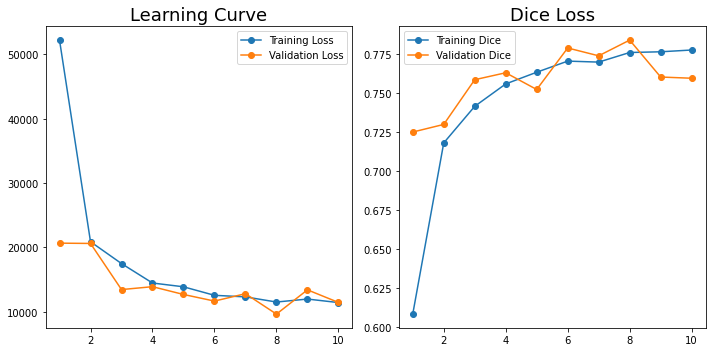

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].set_title('Learning Curve', fontsize=18)
axs[0].plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
axs[0].plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
# axs[0].xlabel('Epoch', fontsize=15)
# axs[0].ylabel('Loss', fontsize=15)
axs[0].legend()

axs[1].set_title('Dice Loss', fontsize=18)
axs[1].plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training Dice')
axs[1].plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation Dice')
# axs[1].xlabel('Epoch', fontsize=15)
# axs[1].ylabel('Loss', fontsize=15)
axs[1].legend()

plt.tight_layout()
plt.show()

In [20]:
!ls ./RES_UNET

epoch_001.pth  epoch_003.pth  epoch_005.pth  epoch_007.pth  epoch_009.pth
epoch_002.pth  epoch_004.pth  epoch_006.pth  epoch_008.pth  epoch_010.pth


In [21]:
best_epoch = np.argmin(valid_loss) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch: {best_epoch:03}')

state_dict = torch.load(f'./RES_UNET/epoch_{best_epoch:03}.pth')
model.load_state_dict(state_dict)
model.cuda()

Best epoch is epoch: 008


RES_UNET(
  (inital): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (resblock1): ResBlock(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 8, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 8, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
    (conv1x1x1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (resblock2): ResBlock(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 16, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
    (conv1x1x1): Conv3d(8, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  

Sample batch 'image 'shape is: torch.Size([1, 1, 16, 192, 192])
Sample batch 'mask' shape is: torch.Size([1, 4, 16, 192, 192])
Predicted mask shape is: torch.Size([1, 4, 16, 192, 192])


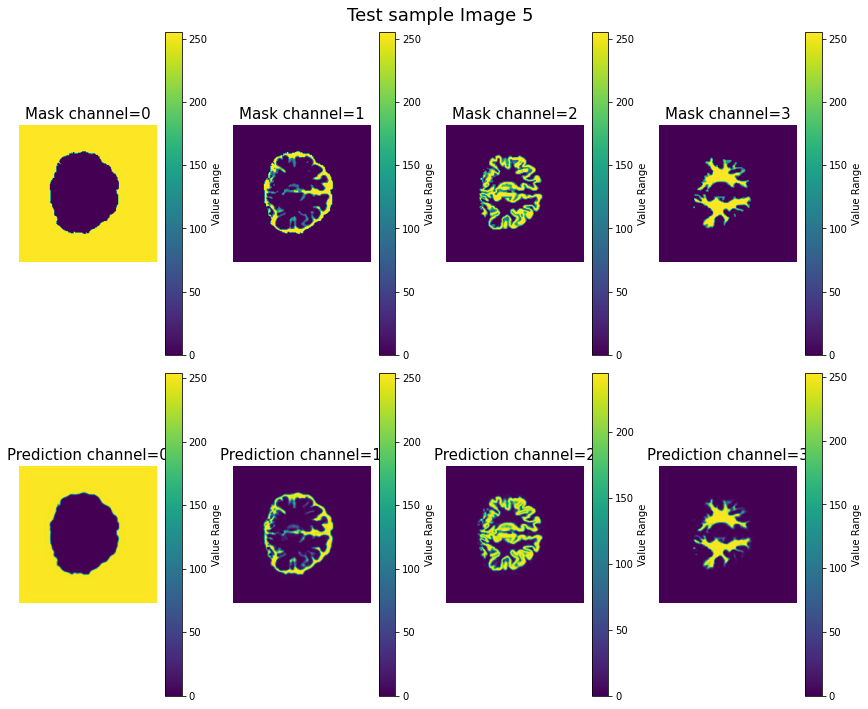

In [22]:
skip = 5
for i, batch in enumerate(test_dataloader):
    if (i < skip):
        continue
    
    sample_batch = batch
    break

# Generate network prediction
with torch.no_grad():
    y_pred = model(sample_batch['image'].cuda())

print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(
    sample_batch['image'].shape, 
    sample_batch['mask'].shape,
    y_pred.shape
))

img_id = sample_batch['img_id'][0]

plt.figure(figsize=(12,10))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)
layer_depth = 5

for channel in range(0, 4):
    truth_mask = (sample_batch['mask'][0][channel,:,:].numpy() * 255).astype('uint8')
    prediction_mask = (y_pred.cpu().numpy()[0][channel,:,:] * 255).astype('uint8')

    # 1 depth * 4 channels * 2 masks = 8 images
    plt.subplot(2, 4, channel + 1)
    plt.title(f'Mask channel={channel}', fontsize=15)
    plt.imshow(truth_mask[layer_depth])
    plt.colorbar(label='Value Range')
    plt.axis('off')

    plt.subplot(2, 4, channel + 5)
    plt.title(f'Prediction channel={channel}', fontsize=15)
    plt.imshow(prediction_mask[layer_depth])
    plt.colorbar(label='Value Range')
    plt.axis('off')

plt.tight_layout()
plt.show()

(16, 192, 192)


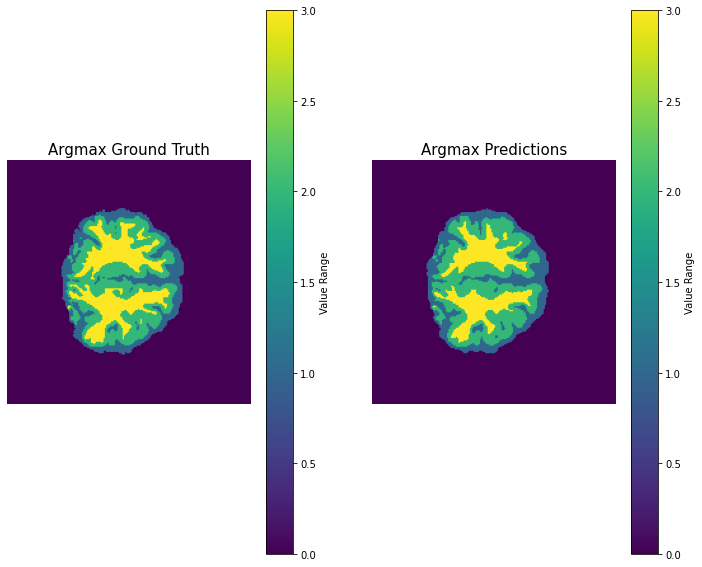

(16, 192, 192) (16, 192, 192)
[0 1 2 3]
[0 1 2 3]


In [23]:
# ok now lets see what argmax does
plt.figure(figsize=(12,10))
final_mask = np.argmax(sample_batch['mask'].cpu().numpy(), axis=1)[0]
plt.subplot(1, 2, 1)
plt.title(f'Argmax Ground Truth', fontsize=15)
plt.imshow(final_mask[layer_depth])
plt.colorbar(label='Value Range')
plt.axis('off')

final_predications = np.argmax(y_pred.cpu().numpy(), axis=1)[0]
print(final_predications.shape)
plt.subplot(1, 2, 2)
plt.title(f'Argmax Predictions', fontsize=15)
plt.imshow(final_predications[layer_depth])
plt.colorbar(label='Value Range')
plt.axis('off')
plt.show()

print(final_mask.shape, final_predications.shape)

vectorized_truth = final_mask.reshape(-1)
vectorized_pred = final_predications.reshape(-1)

print(np.unique(vectorized_truth))
print(np.unique(vectorized_pred))

In [24]:
# Run model against test dataset and score it
def test_network(net, test_dataloader, loss_function):
    if not os.path.isdir('/kaggle/working/pred_mask'):
        os.mkdir('/kaggle/working/pred_mask')

    net.eval()

    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_accuracy = list()
    test_batch_CM = list()
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            # SKIP OVER MISSIZED TENSORS
            if(batch['image'].shape != (1, 1, 16, 192, 192)):
                # print("Batch ", i, batch['image'].shape, batch['mask'].shape)
                continue
            
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            truth_mask_cpu = true_masks.cpu().numpy()
            img_ids = batch['img_id'].numpy().astype('int')

            y_pred = net(imgs)
            
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            dice_score = dice_coefficient(y_pred, true_masks)
            test_batch_dice.append(dice_score.cpu().item())

            final_mask = np.argmax(truth_mask_cpu, axis=1)[0]
            final_predications = np.argmax(y_pred.cpu().numpy(), axis=1)[0]

            vectorized_truth = final_mask.reshape(-1)
            vectorized_pred = final_predications.reshape(-1)
            
            # print(np.unique(vectorized_truth), np.unique(vectorized_pred))
            
            # Accuracy
            test_accuracy = accuracy_score(vectorized_truth, vectorized_pred)
            test_batch_accuracy.append(test_accuracy)
            
            # Confusion Matrix
            test_cm = confusion_matrix(vectorized_truth, vectorized_pred, labels = [0, 1, 2, 3])
            test_batch_CM.append(test_cm)
            
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss} - Dice: {dice_score} - Accuracy: {test_accuracy}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_accuracy = np.array(test_batch_accuracy).mean()
    
    # test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_accuracy, test_batch_CM

In [25]:
# test_loss, test_dice, test_accuracy, test_CM, test_batch_CM = test_network(model, test_dataloader, loss_func)
test_loss, test_dice, test_accuracy, test_batch_CM = test_network(model, test_dataloader, loss_func)

In [26]:
print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}')

Test Loss: 10370.514631266235, Test DICE score: 0.7787380666341833, Test overall accuracy: 0.9768219267595627


In [27]:
test_CM = np.array(test_batch_CM).mean(axis=0)

[[4.26780866e+05 9.28209677e+02 6.45161290e-01 7.47311828e-01]
 [1.71547849e+03 3.82910323e+04 1.13164516e+03 3.14838710e+01]
 [3.06451613e-01 2.45205376e+03 6.21600645e+04 1.20833333e+03]
 [5.37634409e-03 6.45161290e-02 6.20201075e+03 4.89210538e+04]]


<AxesSubplot:title={'center':'Confusion matrix'}>

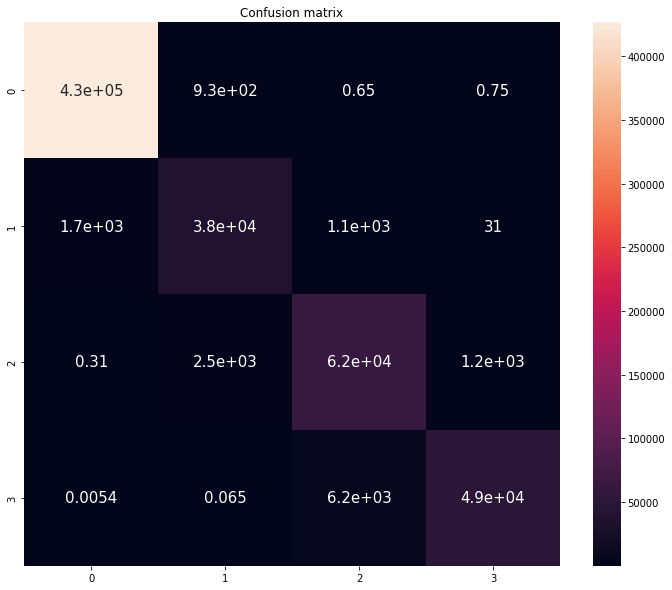

In [28]:
# Generate correlation matrix
print(test_CM)
df_cm = pd.DataFrame(test_CM)

plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
plt.ylim([0, 4]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');
sns.heatmap(df_cm, annot = True, annot_kws = {"size": 15})